In [ ]:
!pip install pyupbit

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup


coin_list = ["BTC", "MED", "MBL"]
time_units = ["days", "weeks"]
minutes_units = [1, 3, 5, 15, 30, 60, 240]
count = 400  # max : 400

for coin in coin_list:

    for time_unit in time_units:
        req = requests.get(
            f"https://crix-api-endpoint.upbit.com/v1/crix/candles/{time_unit}?code=CRIX.UPBIT.KRW-{coin}&count={count}"
        )
        data = req.json()
        result = []

        for i, candle in enumerate(data):
            result.append(
                {
                    "Time": data[i]["candleDateTimeKst"],
                    "OpeningPrice": data[i]["openingPrice"],
                    "HighPrice": data[i]["highPrice"],
                    "LowPrice": data[i]["lowPrice"],
                    "TradePrice": data[i]["tradePrice"],
                    "CandleAccTradeVolume": data[i]["candleAccTradeVolume"],
                    "candleAccTradePrice": data[i]["candleAccTradePrice"],
                }
            )

        coin_data = pd.DataFrame(result)
        coin_data.to_csv(f"{coin}_KRW_{time_unit}.csv")
    

    for minute_unit in minutes_units:
        req = requests.get(
            f"https://crix-api-endpoint.upbit.com/v1/crix/candles/minutes/{minute_unit}?code=CRIX.UPBIT.KRW-{coin}&count={count}"
        )
        data = req.json()
        result = []

        for i, candle in enumerate(data):
            result.append(
                {
                    "Time": data[i]["candleDateTimeKst"],
                    "OpeningPrice": data[i]["openingPrice"],
                    "HighPrice": data[i]["highPrice"],
                    "LowPrice": data[i]["lowPrice"],
                    "TradePrice": data[i]["tradePrice"],
                    "CandleAccTradeVolume": data[i]["candleAccTradeVolume"],
                    "candleAccTradePrice": data[i]["candleAccTradePrice"],
                }
            )
        
        coin_data = pd.DataFrame(result)
        coin_data.to_csv(f"{coin}_KRW_{minute_unit}.csv")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
import pyupbit

code = "KRW-BTC"

#df = pyupbit.get_ohlcv(code,interval='minute30',count=200)

# data = pd.read_csv('/content/MED_KRW_days.csv')
data_path = '/content/BTC_KRW_15_2021_2_26_0_16_31.csv'
INTERVAL = 'minute15'

data = pd.read_csv(data_path)
data = data.sort_values(by=['Time'], axis=0)


trade_prices = data["TradePrice"].values

In [ ]:
seq_len = 30
sequence_length = seq_len + 1

result = []
for index in range(len(trade_prices) - sequence_length):
    result.append(trade_prices[index : index + sequence_length])


def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        # normalized_window = [((float(p) - min(window))/(max(window)-min(window))) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)


result = normalize_windows(result)
# result=np.array(result)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((332, 30, 1), (37, 30, 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(seq_len, return_sequences=True, input_shape=(seq_len, 1)))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))

model.add(Dense(32, activation="linear"))
model.add(Dense(1, activation="linear"))



model.summary()

loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 64)            24320     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start_time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=100,
    callbacks=[
        TensorBoard(log_dir="logs/%s" % (start_time)),
        ModelCheckpoint(
            "./models/%s_eth.h5" % (start_time),
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            mode="auto",
        ),
        ReduceLROnPlateau(
            monitor="val_loss", factor=0.2, patience=5, verbose=0, mode="auto"
        ),
    ],
)

Epoch 1/100
6/6 [==============================] - 5s 261ms/step - loss: 7.4995e-04 - mse: 0.0015 - val_loss: 1.5519e-04 - val_mse: 3.1038e-04

Epoch 00001: val_loss improved from inf to 0.00016, saving model to ./models/2021_02_25_21_38_10_eth.h5
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 4.3188e-04 - mse: 8.6376e-04 - val_loss: 2.0888e-04 - val_mse: 4.1777e-04

Epoch 00002: val_loss did not improve from 0.00016
Epoch 3/100
6/6 [==============================] - 0s 19ms/step - loss: 2.8720e-04 - mse: 5.7440e-04 - val_loss: 1.4086e-04 - val_mse: 2.8172e-04

Epoch 00003: val_loss improved from 0.00016 to 0.00014, saving model to ./models/2021_02_25_21_38_10_eth.h5
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 2.4903e-04 - mse: 4.9807e-04 - val_loss: 1.5442e-04 - val_mse: 3.0884e-04

Epoch 00004: val_loss did not improve from 0.00014
Epoch 5/100
6/6 [==============================] - 0s 16ms/step - loss: 2.2417e-04 - mse: 4.4835e-04 

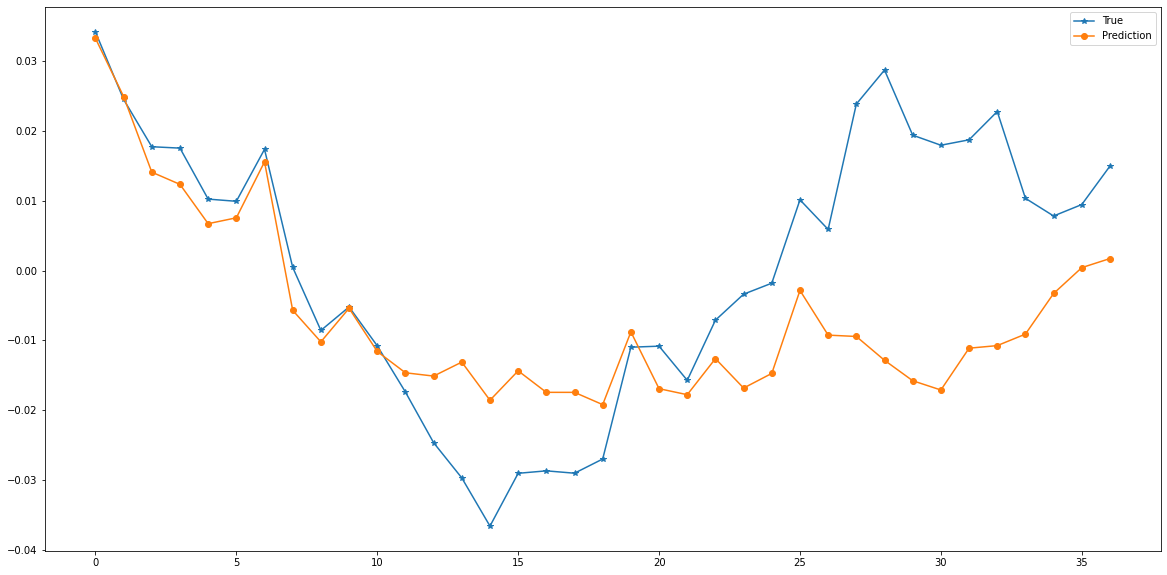

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor="white", figsize=(20, 10))

ax = fig.add_subplot(111)
ax.plot(y_test, label="True",marker='*')
ax.plot(pred, label="Prediction",marker='o')
ax.legend()
plt.show()

In [ ]:
def load_price_info(code,interval,count=200):
    df = pyupbit.get_ohlcv(code,interval,count)
    df['Time']=0
    time_idx = list(df.index)
    for time,idx in enumerate(time_idx):
        df['Time'][idx]=str(idx)
    return df

def input_reshape(data):
    data=np.array(data)
    return np.reshape(data, (data.shape[0], data.shape[1], 1))

In [ ]:
df = load_price_info(code,interval=INTERVAL,count=200)

current_prices = df["close"].values

time_len = 5

new_data=[]
future_price=[]
for index in range(len(current_prices) - sequence_length):
    new_data.append(current_prices[index : index + sequence_length-1])
for i in range(time_len):
    windowed_current_prices = normalize_windows([new_data[-1-i]])
    windowed_current_prices = input_reshape(windowed_current_prices)
    pred = model.predict(windowed_current_prices[-time_len:])
    origin_price=(pred+1)*new_data[-1-i][0]

    future_price.append(origin_price[0][0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:

future=(future_price[0]-current_prices[-1])/current_prices[-1]
now=(future_price[1]-current_prices[-2])/current_prices[-2]
past=(future_price[2]-current_prices[-3])/current_prices[-3]

print('future : ',future)
print('now : ', now)
print('past : ',past)

future :  0.004155492356914326
now :  0.0041259657910161455
past :  0.002836949783013019


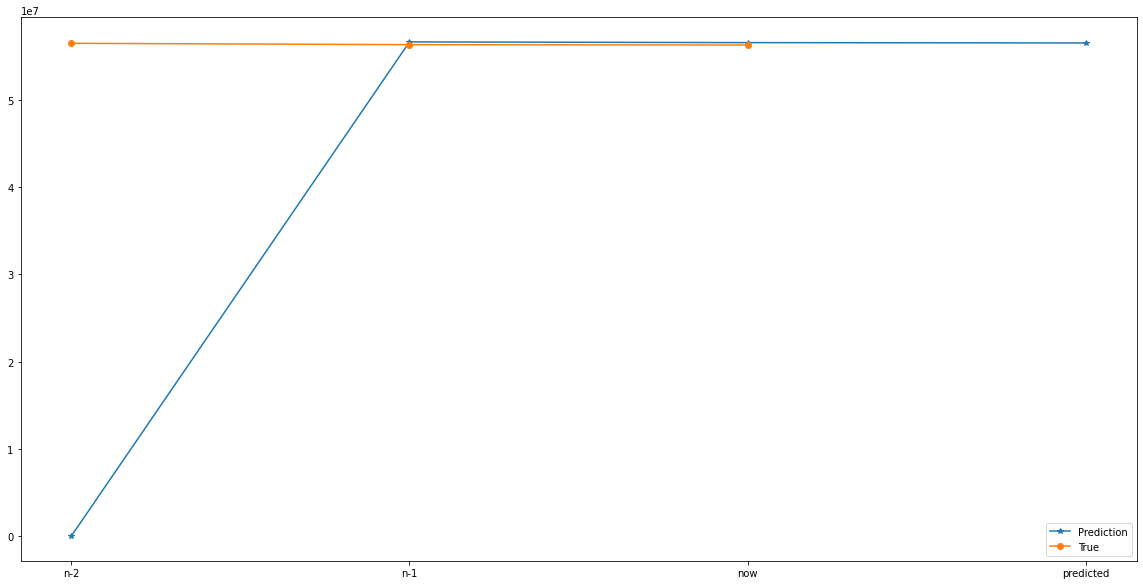

[56455000.0, 56301000.0, 56260000.0]


In [ ]:
import seaborn as sns
fig = plt.figure(facecolor="white", figsize=(20, 10))

ax = fig.add_subplot(111)
ax.plot([0,future_price[2],future_price[1],future_price[0]], label="Prediction",marker='*')
ax.plot([current_prices[-3],current_prices[-2],current_prices[-1]], label="True",marker='o')
sns.lineplot(x=['n-2','n-1','now','predicted'], ax=ax)
ax.legend()
plt.show()
print([current_prices[-3],current_prices[-2],current_prices[-1]])